# Gerrymandering, the Efficiency Gap, and Thomas Schelling's Model

#### by David Lowry-Duda, davidlowryduda.com

[This note is more about modeling some of the mathematics behind political events than politics themselves. And there are pretty pictures.]

Gerrymandering has become a recurring topic in the news. The Supreme Court of the US, as well as more state courts and supreme courts, is hearing multiple cases on partisan gerrymandering (all beginning [with a case in Wisconsin](https://www.nytimes.com/2017/10/01/us/wisconsin-supreme-court-gerrymander.html)).

Intuitively, it is clear that gerrymandering is bad. It allows politicians to choose their voters, instead of the other way around. And it allows the majority party to quash minority voices.

But how can one identify a gerrymandered map? To quote Justice Kennedy in his Concurrence the 2004 Supreme Court case Vieth v. Jubelirer:

>  When presented with a claim of injury from partisan gerrymandering, courts confront two obstacles. First is the lack of comprehensive and neutral principles for drawing electoral boundaries. No substantive definition of fairness in districting seems to command general assent. Second is the absence of rules to limit and confine judicial intervention. With uncertain limits, intervening courts–even when proceeding with best intentions–would risk assuming political, not legal, responsibility for a process that often produces ill will and distrust.

Later, he adds to the first obstacle, saying:

> The object of districting is to establish “fair and effective representation for all citizens.” Reynolds v. Sims, 377 U.S. 533, 565—568 (1964). At first it might seem that courts could determine, by the exercise of their own judgment, whether political classifications are related to this object or instead burden representational rights. The lack, however, of any agreed upon model of fair and effective representation makes this analysis difficult to pursue.

From Justice Kennedy's Concurrence emerges a theme --- a "workable standard" of identifying gerrymandering would open up the possibility of limiting partisan gerrymandering through the courts. Indeed, at the core of the Wisconsin gerrymandering case is a proposed "workable standard", based around the **efficiency gap.**


## Thomas Schelling and Segregation

In 1971, American economist Thomas Schelling (who later won the Nobel Prize in Economics in 2005) published *Dynamic Models of Segregation* (Journal of Mathematical Sociology, 1971, Vol 1, pp 143--186). He sought to understand why racial segregation in the United States seems so difficult to combat.

He introduced a simple model of segregation suggesting that even if each individual person doesn't mind living with others of a different race, they might still *choose* to segregate themselves through mild preferences. As each individual makes these choices, overall segregation increases.

I write this post because I wondered what happens if we adapt Schelling's model to instead model a state and its district voting map. In place of racial segregation, I consider political segregation. Supposing the district voting map does not change, I wondered how the efficiency gap will change over time as people further segregate themselves.

It seemed intuitive to me that political segregation (where people who had the same political beliefs stayed largely together and separated from those with different political beliefs) might correspond to more egregious cases of gerrymandering. But to my surprise, I was (mostly) wrong.

Let's set up and see the model.


## Schelling's Model

Let us first set up Schelling's model of segregation. Let us model a state as a grid, where each square on that grid represents a house. Initially ten percent of the houses are empty (White), and the remaining houses are randomly assigned to be either Red or Blue.

We suppose that each person wants to have a certain percentage ($p$) of their neighbors that are like itself. By "neighbor", we mean those in the adjacent squares. We will initially suppose that $p = 0.33$, which is a pretty mild condition. For instance, each person doesn't mind living with 66 percent of their neighbors being different, so long as there a couple of similar people nearby.

At each step (which I'll refer to as a year), if a person is unhappy (i.e. fewer than $p$ percent of their neighbors are like that person) then they leave their house and move randomly to another empty house. Notice that after moving, they may or may not be happy, and they will cause other people to perhaps become happy or become unhappy.

We also introduce a measure of segregation. We call the segregation the value of 
$$\text{segregation} = \frac{(\sum \text{number of same neighbors})}{(\sum \text{number of neighbors})},$$
summed across the houses in the grid, and where empty spaces aren't the same as anything, and don't count as a neighbor. Thus high segregation means that more people are surrounded only by people like them, and low segregation means people are very mixed. (Note also that 50 percent segregation is considered "very unsegregated", as it means half your neighbors are the same and half are different).

To get to a specific example, here is an instance of this model for $400$ spaces in a $20$ by $20$ grid.

0.49231263528138525

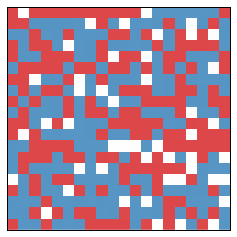

In [101]:
grid = Schelling(n=20, p=0.33)
viewer = SchellingViewer(grid)
viewer.draw(grid=False)
grid.segregation()

Initially, there is a lot of randomness, and segregation is a low $0.50$. After one year, the state looks like.

0.59692598487863113

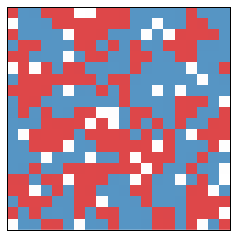

In [97]:
grid.step()
viewer.draw(grid=False)
grid.segregation()

And after another year,

0.63261705796524736

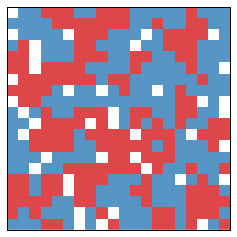

In [98]:
grid.step()
viewer.draw(grid=False)
grid.segregation()

From year to year, the changes are small. But already significant segregation is occurring. The segregation measure is now at $0.63$. After another 10 years,

0.7060717601803953

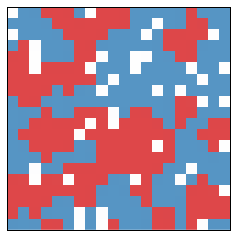

In [99]:
for year in range(10):
    grid.step()

viewer.draw(grid=False)
grid.segregation()

That map appears extremely segregated, and now the segregation measure is $0.75$. Further, it didn't even take very long!

Let's look at a larger model. Here is a 200 by 200 grid. And since we're working larger, suppose each square "neighbors" the nearest 24, so that a neighborhood around 'o' looks like

    xxxxx
    xxxxx
    xxoxx
    xxxxx
    xxxxx
    
Then we get

0.50136095542238701

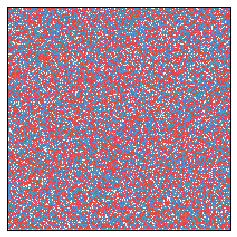

In [110]:
grid = Schelling(n=200, p=0.33, size=5)
viewer = SchellingViewer(grid)
viewer.draw(grid=False)
grid.segregation()

Initially this looks quite a bit like red, white, and blue static. Going forward a couple of years, we get

0.52775873835678966

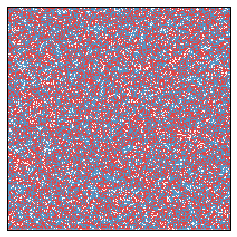

In [111]:
grid.step()
viewer.draw(grid=False)
grid.segregation()

0.54647885562932885

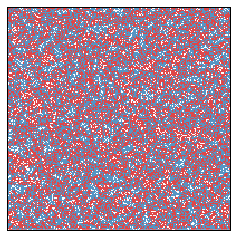

In [112]:
grid.step()
viewer.draw(grid=False)
grid.segregation()

Let us now fast forward ten years.

0.66839549240733542

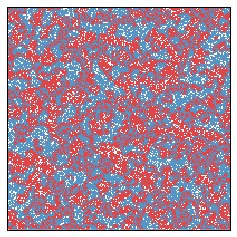

In [113]:
for year in range(10):
    grid.step()

viewer.draw(grid=False)
grid.segregation()

There is no static here. This is a segregated society. And after another 10 years, we have

0.72852013010629646

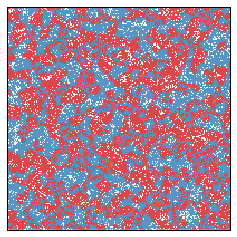

In [116]:
for year in range(10):
    grid.step()

viewer.draw(grid=False)
grid.segregation()

Let's see how these change over time with a variety of parameters.

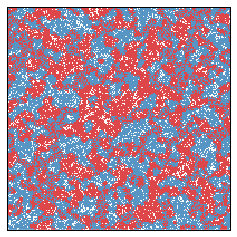

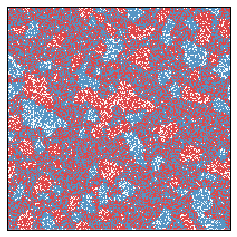

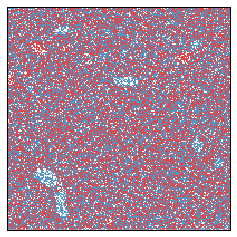

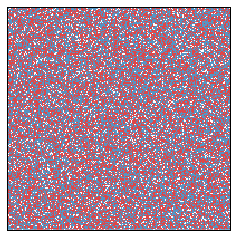

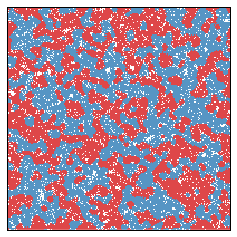

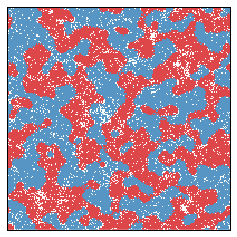

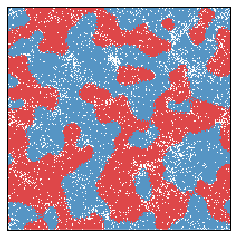

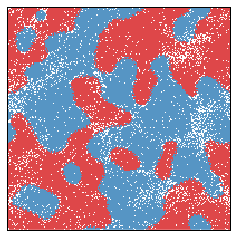

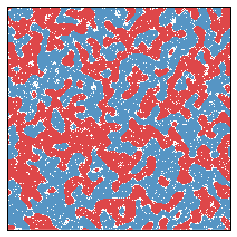

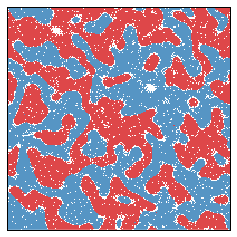

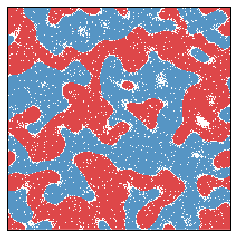

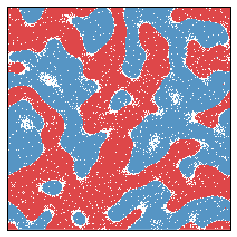

In [145]:
for p in [0.33, 0.4, 0.5]:
    for size in [5,7,9,11]:
        save_schelling_anim(n=200, p=p, size=size)

In [144]:
def save_schelling_anim(n=200, p=0.33, size=3):
    grid = Schelling(n=n, p=p, size=size)
    savename = "schelling_{}_p{}_size{}.mp4".format(n, p, size)
    viewer = SchellingViewer(grid)
    anim = viewer.animate(frames=30)
    anim.save(savename, fps=2, writer='avconv')

I particularly note that when $p \geq 0.4$, segregation occurs in an extreme fashion. This is the 200x200, $p=0.4$, $size=9$ case.

<video controls src="schelling_200_p0.4_size9.mp4" />


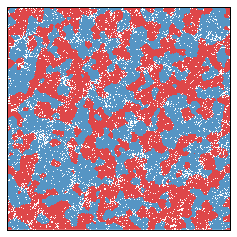

In [150]:
grid = Schelling(n=1000, p=0.4, size=13)
viewer = SchellingViewer(grid)
anim = viewer.animate(frames=30)
anim.save("schelling_1000_p4_size9.mp4", fps=2, writer='avconv')

<video controls src="schelling_1000_p4_size9.mp4" />

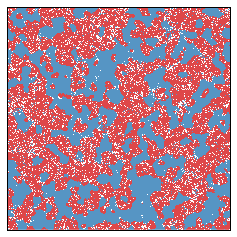

In [151]:
grid = Schelling(n=1000, p=0.4, size=13, red_prob=0.5)
viewer = SchellingViewer(grid)
anim = viewer.animate(frames=30)
anim.save("schelling_1000_p4_size9_redfavor.mp4", fps=2, writer='avconv')

<video controls src="schelling_1000_p4_size9_redfavor.mp4" />

It should be noted that there are many reasons why we shouldn't expect Schelling's model to perfectly predict true behavior. But the point of the model is that individuals acting with mild preferences can create systemic and large-effect segregation even without high-order coordination. And as we have seen above, it doesn't take much for these segregated positions to emerge.

## Altering Schelling to Model Voting Districts

Given a Schelling model, we now adapt it incorporate voting districts. Let us suppose that our square is divided up into (regular rectangular) regions of voters. We will assume a totally polarized voter base, so that Red people will always vote for the Red party and Blue people will always vote for the Blue party. (This is a pretty strong assumption).

Before we describe exactly how we set up the model, let's look at an example.

0.50466519941309862

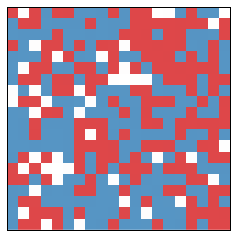

In [265]:
dgrid = Districts(20, cols=5, p=.33)
viewer = District_Viewer(dgrid)
viewer.draw(grid=False)
dgrid.segregation()

Given a typical Schelling model, we separate it into (in this case, 10) districts.

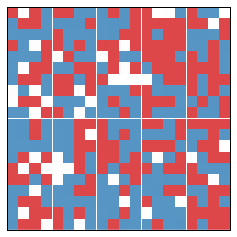

In [266]:
viewer.draw(grid=True)

Each of the 10 areas vote, giving some tallies. In this case, we have the following table which describes the results of this year's vote. Districts are numbered from top left to bottom right, sequentially.

In [268]:
print(dgrid.votes_to_md_table())

|District|Blue Vote|Red Vote|Winner|Blue Wasted|Red Wasted|Net Wasted|
|-|-|-|-|-|-|-|
|0|18|14|blue|3|14|-11|
|1|20|16|blue|3|16|-13|
|2|19|15|blue|3|15|-12|
|3|12|25|red|12|12|0|
|4|18|20|red|18|1|17|
|5|19|15|blue|3|15|-12|
|6|21|13|blue|7|13|-6|
|7|23|15|blue|7|15|-8|
|8|22|15|blue|6|15|-9|
|9|14|23|red|14|8|6|



|District|Blue Vote|Red Vote|Winner|Blue Wasted|Red Wasted|Net Wasted|
|-|-|-|-|-|-|-|
|0|18|14|blue|3|14|-11|
|1|20|16|blue|3|16|-13|
|2|19|15|blue|3|15|-12|
|3|12|25|red|12|12|0|
|4|18|20|red|18|1|17|
|5|19|15|blue|3|15|-12|
|6|21|13|blue|7|13|-6|
|7|23|15|blue|7|15|-8|
|8|22|15|blue|6|15|-9|
|9|14|23|red|14|8|6|

"Blue Wasted" refers to a wasted blue vote (similarly for Red). This is a key idea counted in the efficiency gap, and contributes towards the overall measure of gerrymandering.

A wasted vote is one that doesn't contribute to winning an additional election. A vote can be wasted in two different ways. All votes for a losing candidate are wasted, since they didn't contribute to a win. On the other hand, excess voting for a single candidate is also wasted.

So in District 0, the Blue candidate won and so all 14 Red votes are wasted. The Blue candidate only needed 15 votes to win, but received 18. So there are three excess Blue votes, which means that there are 3 Blue votes wasted.

I adopt that convention (for ease of summing up) that the net wasted votes is the number of Blue wasted votes minus the number of Red wasted votes. So if it is positive, this means that more Blue votes were wasted than Red. And if it's negative, then more Red votes were wasted than Blue.

### Aside: How the Efficiency Gap measures Gerrymandering

With this example in mind, a rough definition of gerrymandering in a competitive district is to draw lines so that one party has many more wasted votes. In this example, there are 186 Blue voters and 171 Red voters, so it might be expected that approximately half of the winners would be Red and half would be Blue. But in fact there are 7 Blue winners and only 3 Red winners.

And a big reason why is that the overall net wasted number of votes is $-48$, which means that $48$ more Red votes than Blue votes did not contribute to a winning election.

So roughly, more wasted votes corresponds to more gerrymandering. The efficiency gap is defined to be

$$ \text{Efficiency Gap} = \frac{\text{Net Wasted Votes}}{\text{Number of Voters}}.$$

In this case, there are $48$ wasted votes and $357$ voters, so the efficiency gap is $48/357 = 0.134$. This number, 13.4 percent, is very high. The proposed gap to raise flags in gerrymandering cases is 7 percent --- any higher, and one should consider redrawing district lines.

The efficiency gap is extremely easy to compute, which is a good plus. But whether it is a good indicator of gerrymandering is more complicated, and is one of the considerations in teh Supreme Court case concerining gerrymandering in Wisconsin.


### A More Complete Description of the Model

With this example in mind, we are now prepared to describe the model explicitly. The initial setup is the same as in Schelling's model. A state is a rectangular grid, where each square on this grid represents a house. Unoccupied houses are White. If a Red person occupies a house, then the house is colored Red. If a Blue person occupies a house, then that house is colored Blue. Each year, all the Red people vote for the Red candidate, and all Blue people vote for the Blue candidate, and we can tally the results. We will then measure the efficiency gap.

At the same time, each year people may move as in Schelling's model. A person is satisfied if they have at least $p$ percent of their neighbors which are similar to them. We will again default to $33$ percent, and a person's neighbors will be all those people which adjacent (or for larger models, perhaps 2-step adjacent, or that flavor) away.

At each step, we can measure the segregation (which we know will increase from Schelling's model) and the efficiency gap.

At last, we are prepared to investigate the relationship between segregation and the efficiency gap.

## Simulations

First simulation: increase in efficiency gap.

segregation: 0.5176112836438923    eff_gap: 0.059782608695652176


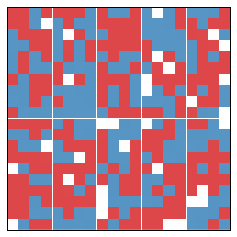

In [282]:
dgrid = Districts(20, cols=5, p=.33)
viewer = District_Viewer(dgrid)
viewer.draw(grid=True)
print("segregation: {}    eff_gap: {}".format(dgrid.segregation(), dgrid.efficiency_gap()))

In [283]:
dgrid.step()
print("segregation: {}    eff_gap: {}".format(dgrid.segregation(), dgrid.efficiency_gap()))

segregation: 0.6089188664596273    eff_gap: 0.01358695652173913


In [284]:
dgrid.step()
print("segregation: {}    eff_gap: {}".format(dgrid.segregation(), dgrid.efficiency_gap()))

segregation: 0.6549333592132506    eff_gap: 0.002717391304347826


In [285]:
for year in range(10):
    dgrid.step()

print("segregation: {}    eff_gap: {}".format(dgrid.segregation(), dgrid.efficiency_gap()))

segregation: 0.7183553312629398    eff_gap: 0.12771739130434784


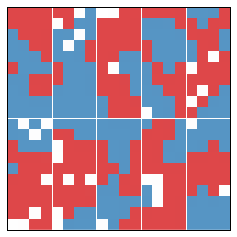

In [286]:
viewer.draw(grid=True)

Second simulation, decrease in efficiency gap.

segregation: 0.514740319204605    eff_gap: 0.12637362637362637


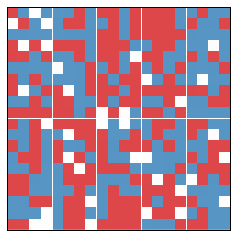

In [287]:
dgrid = Districts(20, cols=5, p=.33)
viewer = District_Viewer(dgrid)
viewer.draw(grid=True)
print("segregation: {}    eff_gap: {}".format(dgrid.segregation(), dgrid.efficiency_gap()))

In [288]:
dgrid.step()
print("segregation: {}    eff_gap: {}".format(dgrid.segregation(), dgrid.efficiency_gap()))

segregation: 0.588154107796965    eff_gap: 0.024725274725274724


In [289]:
dgrid.step()
print("segregation: {}    eff_gap: {}".format(dgrid.segregation(), dgrid.efficiency_gap()))

segregation: 0.6645408163265306    eff_gap: 0.013736263736263736


In [291]:
for year in range(10):
    dgrid.step()

print("segregation: {}    eff_gap: {}".format(dgrid.segregation(), dgrid.efficiency_gap()))

segregation: 0.7903846153846154    eff_gap: 0.03021978021978022


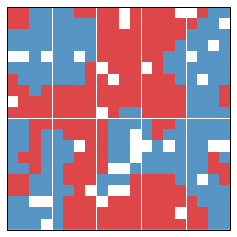

In [292]:
viewer.draw(grid=True)

Large simulation --- there tends to be decrease in efficiency gap, even with high individual prejudice.

segregation: 0.5019318687823641    eff_gap: 0.06154443796997697


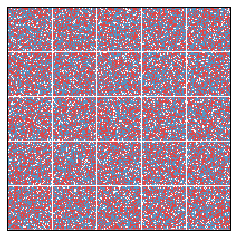

In [323]:
dgrid = Districts(200, rows=5, cols=5, p=.5, size=11)
viewer = District_Viewer(dgrid)
viewer.draw(grid=True)
print("segregation: {}    eff_gap: {}".format(dgrid.segregation(), dgrid.efficiency_gap()))

segregation: 0.6151223410088806    eff_gap: 0.021032770054663003
segregation: 0.6964527515826109    eff_gap: 0.06096173589722245
segregation: 0.754443499700721    eff_gap: 0.0604900246954688
segregation: 0.7911164029972821    eff_gap: 0.020366824828657842
segregation: 0.8170164861083035    eff_gap: 0.019145925247648382
segregation: 0.8345797013552778    eff_gap: 0.020339077110907627
segregation: 0.8461427699357442    eff_gap: 0.021116013207913648
segregation: 0.8549311328071838    eff_gap: 0.021199256361164293
segregation: 0.8611477116721435    eff_gap: 0.021060517772413218
segregation: 0.864931278152372    eff_gap: 0.0213934903854158
segregation: 0.8679687283220956    eff_gap: 0.021060517772413218
segregation: 0.8702085967714869    eff_gap: 0.021143760925663863
segregation: 0.872043018211752    eff_gap: 0.021060517772413218
segregation: 0.8726874919894981    eff_gap: 0.021116013207913648
segregation: 0.8735303949821556    eff_gap: 0.020949526901412358
segregation: 0.874031868914496   

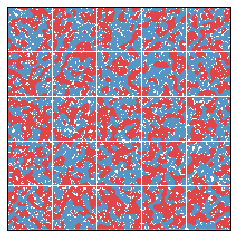

In [324]:
for i in range(20):
    dgrid.step()
    print("segregation: {}    eff_gap: {}".format(dgrid.segregation(), dgrid.efficiency_gap()))
    
viewer.draw(grid=True)

What about when one group is much larger than the other, and there is high prejudice? Sometimes it's high...

segregation: 0.5058062620500224    eff_gap: 0.33954520244037717


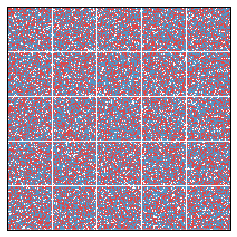

In [328]:
dgrid = Districts(200, rows=5, cols=5, p=.5, size=11, red_prob=0.4)
viewer = District_Viewer(dgrid)
viewer.draw(grid=True)
print("segregation: {}    eff_gap: {}".format(dgrid.segregation(), dgrid.efficiency_gap()))

segregation: 0.6191077040910652    eff_gap: 0.30013865779256793
segregation: 0.6985964199878509    eff_gap: 0.2593732667775929
segregation: 0.753262683886644    eff_gap: 0.26006655574043264
segregation: 0.7915991205134301    eff_gap: 0.21955074875207986
segregation: 0.8167161212793492    eff_gap: 0.2195230171935663
segregation: 0.8336759501360167    eff_gap: 0.17958957293399888
segregation: 0.8457361078097351    eff_gap: 0.13924015529672767
segregation: 0.8543615138789848    eff_gap: 0.13907376594564613
segregation: 0.8588846631275914    eff_gap: 0.1389905712701054
segregation: 0.8639151018144362    eff_gap: 0.1391846921797005
segregation: 0.8671631275915802    eff_gap: 0.09936217415418747
segregation: 0.8693813881625861    eff_gap: 0.13874098724348308
segregation: 0.8707296040989884    eff_gap: 0.1386855241264559
segregation: 0.8725140968755778    eff_gap: 0.09925124792013311
segregation: 0.8733830850698571    eff_gap: 0.13863006100942873
segregation: 0.8738636333623855    eff_gap: 0.

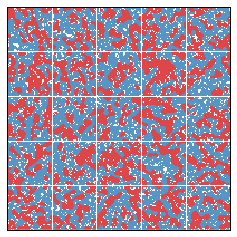

In [329]:
for i in range(20):
    dgrid.step()
    print("segregation: {}    eff_gap: {}".format(dgrid.segregation(), dgrid.efficiency_gap()))
    
viewer.draw(grid=True)

And sometimes it's low.

segregation: 0.5052934954597752    eff_gap: 0.30356056836401835


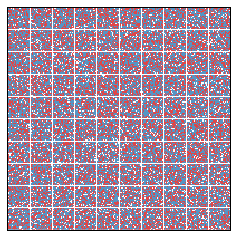

In [330]:
dgrid = Districts(200, rows=10, cols=10, p=.5, size=11, red_prob=0.4)
viewer = District_Viewer(dgrid)
viewer.draw(grid=True)
print("segregation: {}    eff_gap: {}".format(dgrid.segregation(), dgrid.efficiency_gap()))

segregation: 0.6170763597637872    eff_gap: 0.1987338972742854
segregation: 0.6986845656048676    eff_gap: 0.1524022778791397
segregation: 0.7528978324342399    eff_gap: 0.1423398020677835
segregation: 0.7884456607876744    eff_gap: 0.12614032177807266
segregation: 0.813371350641213    eff_gap: 0.13072925305468017
segregation: 0.8296537305141553    eff_gap: 0.11555260684469508
segregation: 0.8413137099258347    eff_gap: 0.06938685243545088
segregation: 0.8505599259662953    eff_gap: 0.04865372919776635
segregation: 0.8571272579358499    eff_gap: 0.05841211920163653
segregation: 0.8612265913165731    eff_gap: 0.058218610051418145
segregation: 0.8646892532653023    eff_gap: 0.05816332172278432
segregation: 0.8675365363705057    eff_gap: 0.05813567755846741
segregation: 0.8691979835556713    eff_gap: 0.0585503400232211
segregation: 0.8701625345222956    eff_gap: 0.038342455907557915
segregation: 0.8717764271628925    eff_gap: 0.037927793442804225
segregation: 0.8724736853883478    eff_gap

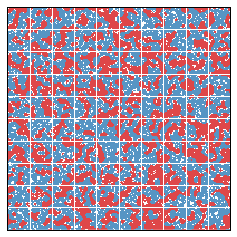

In [331]:
for i in range(20):
    dgrid.step()
    print("segregation: {}    eff_gap: {}".format(dgrid.segregation(), dgrid.efficiency_gap()))
    
viewer.draw(grid=True)

segregation: 0.5068698357033848    eff_gap: 0.3318860546347709


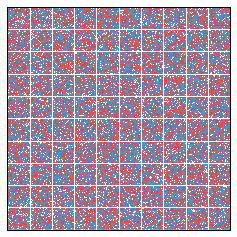

In [353]:
dgrid = Districts(400, rows=10, cols=10, p=.5, size=11, red_prob=0.4)
viewer = District_Viewer(dgrid)
viewer.draw(grid=True)
print("segregation: {}    eff_gap: {}".format(dgrid.segregation(), dgrid.efficiency_gap()))

segregation: 0.6185119387239163    eff_gap: 0.31206251130686485
segregation: 0.6989906490156979    eff_gap: 0.2821149751596877
segregation: 0.7529462542054911    eff_gap: 0.2721510179657385
segregation: 0.7898677900306089    eff_gap: 0.20195104301479286
segregation: 0.8151725949428743    eff_gap: 0.2119984970567361
segregation: 0.8319013623902364    eff_gap: 0.18171001544691687
segregation: 0.8434077664659431    eff_gap: 0.15166506631041346
segregation: 0.8521443614114678    eff_gap: 0.1616151073630304
segregation: 0.8580651742599098    eff_gap: 0.16171947842302287
segregation: 0.8623758812727834    eff_gap: 0.16130895225371908
segregation: 0.8653916416341791    eff_gap: 0.13641993348084444
segregation: 0.8677651306560002    eff_gap: 0.1513310789184375


/home/djlowry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:74: RuntimeWarning: invalid value encountered in true_divide


segregation: 0.8695276596562448    eff_gap: 0.15137282734243449


/home/djlowry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:74: RuntimeWarning: invalid value encountered in true_divide
/home/djlowry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:74: RuntimeWarning: invalid value encountered in true_divide


segregation: 0.8706271093722561    eff_gap: 0.15643134471673695


/home/djlowry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:74: RuntimeWarning: invalid value encountered in true_divide


segregation: 0.8715081916371943    eff_gap: 0.1562991413740798
segregation: 0.8722081818296281    eff_gap: 0.15123366592911117
segregation: 0.8727091960512618    eff_gap: 0.15629218330341363
segregation: 0.8730635689336058    eff_gap: 0.1562365187380843
segregation: 0.8732730151440752    eff_gap: 0.16127416190038826
segregation: 0.8734298202365874    eff_gap: 0.1612672038297221


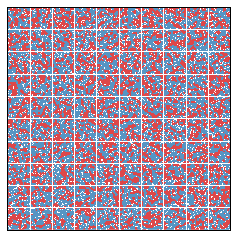

In [354]:
for i in range(20):
    dgrid.step()
    print("segregation: {}    eff_gap: {}".format(dgrid.segregation(), dgrid.efficiency_gap()))
    
viewer.draw(grid=True)

## Result: Segregation Correlates (Weakly) Negatively with Efficiency Gap

There appears to be no positive correlation between segregation and the efficiency gap. And generically, it appears that segregation and the efficiency gap are negatively correlated --- more segregation leads to a smaller efficiency gap. Why might this be?

Perhaps the major reason is that uniform segregation reduces the "cracking" gerrymandering technique. In *cracking*, one tries to divide a larger group into many smaller minorities by splitting them into many districts. This maximizes the number of wasted votes coming from lost elections (as opposed to wasted votes from *packing* lots of people into one district so that they over-win an election). Segregation produces clusters, and these clusters tend to win their local district's election.

The few examples above where high segregation accompanied high efficiency gaps were when the segregated clusters happened to be split by district lines.

This is contrary to my expectations.


## Code

Below, you will find the code used to create these simulations.


### Code for Schelling Plots

The heart of this code is based on code from Allen Downey, presented in his book "Think Complexity." He generously released his code under the MIT license.

In [178]:
"""
Copyright (c) 2018 David Lowry-Duda

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""

'\nCopyright (c) 2018 David Lowry-Duda\n\nPermission is hereby granted, free of charge, to any person obtaining a copy\nof this software and associated documentation files (the "Software"), to deal\nin the Software without restriction, including without limitation the rights\nto use, copy, modify, merge, publish, distribute, sublicense, and/or sell\ncopies of the Software, and to permit persons to whom the Software is\nfurnished to do so, subject to the following conditions:\n\nThe above copyright notice and this permission notice shall be included in all\ncopies or substantial portions of the Software.\n\nTHE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR\nIMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,\nFITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE\nAUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER\nLIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,\nOUT OF O

In [179]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation
from matplotlib.colors import LinearSegmentedColormap
from scipy.signal import correlate2d

In [180]:
# For notebook viewing
%matplotlib inline

In [181]:
class Schelling:
    """A 2D grid of Schelling agents."""
    options = dict(mode='same', boundary='wrap')
    
    def __init__(self, n, m=None, p=0.5, empty_prob=0.1, red_prob=0.45, size=3):
        """
        Initialize grid with attributes.

        Args:
            n: (int) number of rows.
            m: (int) number of columns. In None, defaults to n.
            p: (float) ratio of neighbors that makes one feel comfortable.
            empty_prob: (float) probability an initial cell is empty.
            red_prob: (float) probability an initial cell is Red.
            size: (odd int) size of the neighborhood kernel.
        """
        self.p = p
        m = n if m is None else m
        EMPTY, RED, BLUE = 0, 1, 2
        empty_prob = 0.1
        choices = [EMPTY, RED, BLUE]
        probs = [empty_prob, red_prob, 1 - empty_prob - red_prob]
        self.array = np.random.choice(choices, (n, m), p=probs).astype(np.int8)
        self.kernel = self._make_kernel(size)

    def _make_kernel(self, size):
        """
        Construct size*size adjacency kernel.
        
        Args:
            size: (int) for size of kernel.
            
        Returns:
            np.array such as (for size=3)
            
            [[1,1,1], 
             [1,0,1],
             [1,1,1]]
            
            In the size=n case, it's an n*n array of ones with a zero at
            the center.
        """
        pad = int((size**2-1)/2)
        return np.array([1]*(pad) + [0] + [1]*(pad)).reshape((size,size))   
   
    def count_neighbors(self):
        """
        Surveys neighbors of cells.
        
        Returns:
            This returns the tuple (occupied, frac_red, frac_same)
            where
            
            occupied: logical array indicating occupied cells.
            frac_red: array containing fraction of red neighbors around each cell.
            frac_same: array containing the fraction of similar neighbors.
            
        Note:
            Unoccupied cells do not count in neighbors or similarity.
        """
        a = self.array
        EMPTY, RED, BLUE = 0, 1, 2
        
        # These create np.arrays where each entry is True if condition is true
        red = a==RED
        blue = a==BLUE
        occupied = a!=EMPTY

        # count red neighbors and all neighbors
        num_red = correlate2d(red, self.kernel, **self.options)
        num_neighbors = correlate2d(occupied, self.kernel, **self.options)

        # compute fraction of similar neighbors
        frac_red = num_red / num_neighbors
        frac_blue = 1 - frac_red
        frac_same = np.where(red, frac_red, frac_blue)
        
        # no neighbors is considered the same as no similar neighbors 
        frac_same[num_neighbors == 0] = 0
        frac_red[num_neighbors == 0] = 0
        
        # Unoccupied squares are not similar to anything
        frac_same[occupied == 0] = 0
        
        return occupied, frac_red, frac_same

    def segregation(self):
        """Computes the average fraction of similar neighbors."""
        occupied, _, frac_same = self.count_neighbors()
        return np.sum(frac_same) / np.sum(occupied)
    
    def step(self):
        """Executes one time step."""
        a = self.array
        
        # find the unhappy cells
        occupied, _, frac_same = self.count_neighbors()
        unhappy_locs = locs_where(occupied & (frac_same < self.p))

        # find the empty cells
        empty = a==0
        num_empty = np.sum(empty)
        empty_locs = locs_where(empty)

        # shuffle the unhappy cells
        if len(unhappy_locs):
            np.random.shuffle(unhappy_locs)
            
        # for each unhappy cell, choose a random destination
        for source in unhappy_locs:
            i = np.random.randint(len(empty_locs))
            dest = tuple(empty_locs[i])

            # move
            a[dest] = a[tuple(source)]
            a[tuple(source)] = 0
            empty_locs[i] = source
        
        num_empty2 = np.sum(a==0)
        assert num_empty == num_empty2
        return


In [207]:
def locs_where(condition):
    """
    Find cells where a logical array is True.
    
    Args:
        condition: (2D numpy logical array).
    
    Returns:
        Array with one set of coordinates per row indicating where
        condition was true.
        
    Example:
        Input is (as np.array)
        
        [[1,0],
         [1,1]]
        
        Then the output will be
        
        [[0,0],[1,0],[1,1]]
        
        which are the three locations of the nonzero (True) cells.
    """
    return np.transpose(np.nonzero(condition))


def make_cmap(color_dict, vmax=None, name='mycmap'):
    """
    Makes a custom color map.
    
    Args:
        color_dict: (dict) of form {number:color}.
        vmax: (float) high end of the range. If None, use max value
              from color_dict.
        name: (str) name for map.
    
    Returns:
        pyplot color map.
    """
    if vmax is None:
        vmax = max(color_dict.keys()) 
    colors = [(value/vmax, color) for value, color in color_dict.items()]
    cmap = LinearSegmentedColormap.from_list(name, colors)
    return cmap


class SchellingViewer:
    """Generates animated view of Schelling array"""
    
    # colors from http://colorbrewer2.org/#type=diverging&scheme=RdYlBu&n=5
    colors = ['#fdae61','#abd9e9','#d7191c','#ffffbf','#2c7bb6']
    cmap = make_cmap({0:'white', 1:colors[2], 2:colors[4]})
    
    options = dict(interpolation='none', alpha=0.8)

    def __init__(self, viewee):
        """
        Initialize.
        
        Args:
            viewee: (Schelling) object to view
        """
        self.viewee = viewee
        self.im = None
        self.hlines = None
        self.vlines = None
        
    def step(self, iters=1):
        """Advances the viewee the given number of steps."""
        for i in range(iters):
            self.viewee.step()

    def draw(self, grid=False):
        """
        Draws the array, perhaps with a grid.

        Args:
            grid: (boolean) if True, draw grid lines. If False, don't.
        """
        self.draw_array(self.viewee.array)
        if grid:
            self.draw_grid()            
 
    def draw_array(self, array=None, cmap=None, **kwds):
        """
        Draws the cells.
        
        Args:
            array: (2D np.array) Array to draw. If None, uses self.viewee.array.
            cmap: colormap to color array.
            **kwds: keywords are passed to plt.imshow as options.
        """
        # Note: we have to make a copy because some implementations
        # of step perform updates in place.
        if array is None:
            array = self.viewee.array
        a = array.copy()
        cmap = self.cmap if cmap is None else cmap

        n, m = a.shape
        plt.axis([0, m, 0, n])
        # Remote tickmarks
        plt.xticks([])
        plt.yticks([])

        options = self.options.copy()
        options['extent'] = [0, m, 0, n]
        options.update(kwds)
        self.im = plt.imshow(a, cmap, **options)   
        
    def draw_grid(self):
        a = self.viewee.array
        n, m = a.shape
        lw = 2 if m < 10 else 1
        options = dict(color='white', linewidth=lw)
        rows = np.arange(1, n)
        self.hlines = plt.hlines(rows, 0, m, **options)
        cols = np.arange(1, m)
        self.vlines = plt.vlines(cols, 0, n, **options)

    def animate(self, frames=20, interval=200, grid=False):
        """
        Creates an animation.

        Args:
            frames: (int) number of frames to draw.
            interval: (int) time between frames in ms.
            grid: (boolean) if True, include grid in drawings.
        """
        fig = plt.figure()
        self.draw(grid=grid)
        anim = animation.FuncAnimation(fig, self.animate_func,
                                       init_func=self.init_func,
                                       frames=frames, interval=interval)
        return anim

    def init_func(self):
        """Called at the beginning of an animation."""
        pass
    
    def animate_func(self, i):
        """Draws one frame of the animation."""
        if i > 0:
            self.step()
        a = self.viewee.array
        self.im.set_array(a)
        return (self.im,)

0.47525510204081634

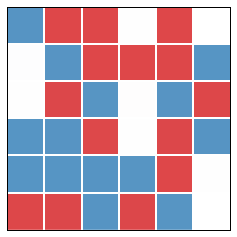

In [208]:
grid = Schelling(n=6)
viewer = SchellingViewer(grid)
viewer.draw(grid=True)
grid.segregation()

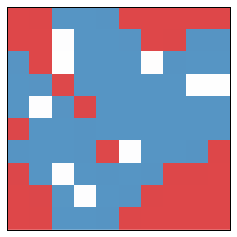

In [209]:
grid = Schelling(n=10)
viewer = SchellingViewer(grid)
anim = viewer.animate(frames=30)
anim.save("test.mp4", fps=2, writer='avconv')

<video controls src="test.mp4" />

0.85603354978354962

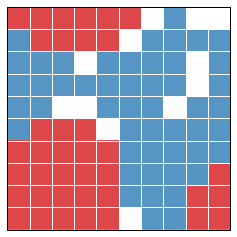

In [185]:
for i in range(10):
    grid.step()
    
viewer.draw(grid=True)
grid.segregation()

### Code for District Analysis

We build on top of Schelling from above.

In [294]:
class Districts(Schelling):
    """A 2D grid of Schelling agents organized into districts."""
    
    def __init__(self, n, m=None, p=0.5, rows=2,
                 cols=2, empty_prob=0.1, red_prob=0.45, size=3):
        """
        Initialize grid.
        
        Args:
            n: (int) number of rows in grid.
            m: (int) number of columns in grid. If None, defaults to n.
            p: (float) ratio of neighbors required to feel comfortable.
            rows: (int) number of rows of districts.
            cols: (int) number of columns of districts.
            empty_prob: (float) probability each initial cell is empty.
            red_prob: (float) probability each initial cell is Red.
            size: (odd int) size of neighborhood kernel.
            
        Note:
            `rows` must divide n, and `cols` must divide m.
            An exception is raised otherwise.
        """
        self.p = p
        self.n = n
        self.m = n if m is None else m
        self.rows = rows
        self.cols = cols
        self.schelling_grid = Schelling(n, m=self.m, p=p, 
                                        empty_prob=empty_prob,
                                        red_prob=red_prob, size=3)
        self.array = self.schelling_grid.array
        self.kernel = self.schelling_grid.kernel
        self.row_mult = self.n//self.rows
        self.col_mult = self.m//self.cols
        try:
            assert(self.row_mult*self.rows==self.n)
            assert(self.col_mult*self.cols==self.m)
        except AssertionError:
            raise Exception(("The number of rows and number of columns must"
                             " divide the size of the grid."))
        self.districts = self.make_districts()
        
    def make_districts(self, array=None):
        """
        Returns array of np.arrays, one for each district.
        """
        if array is None:
            array = self.array
        # double indices works from numpy sugar
        return [array[self.row_mult*i: self.row_mult*(i+1),
                      self.col_mult*j: self.col_mult*(j+1)]
                for i in range(self.rows) for j in range(self.cols)]
    
    def votes(self, output=False):
        """Count votes in each district."""
        votes = dict()
        if output:
            print ("Vote totals\n-----------\n")
        for num, district in enumerate(self.districts):
            IS_RED = 1
            IS_BLUE = 2
            votes[num] = {'red': list(district.flatten()).count(IS_RED),
                          'blue': list(district.flatten()).count(IS_BLUE)}
            if output:
                print ("District {}::   Red vote: {},   Blue vote: {}".format(
                        num, votes[num]['red'], votes[num]['blue']))
        return votes
    
    def tally_votes(self, output=False):
        """Detect winners from votes in each district."""
        tallies = self.votes()
        if output:
            print ("Tallying votes\n--------------\n")
        for num, district in enumerate(self.districts):
            dist_tally = tallies[num]
            dist_tally.update(self.determine_winner(dist_tally))
        return tallies
            
    def determine_winner(self, vote_tally):
        """
        Given a single district's vote_tally, determine the winner.
        
        Returns:
            A dictionary with the keys
            
            'winner'
            'red_wasted'
            'blue_wasted'
            
            computed from vote tally.
        """
        res = dict()
        if vote_tally['red'] > vote_tally['blue']:
            res['winner'] = 'red'
            res['red_wasted'] = vote_tally['red'] - vote_tally['blue'] - 1
            res['blue_wasted'] = vote_tally['blue']
        elif vote_tally['blue'] > vote_tally['red']:
            res['winner'] = 'blue'
            res['blue_wasted'] = vote_tally['blue'] - vote_tally['red'] - 1
            res['red_wasted'] = vote_tally['red']
        else:
            res['winner'] = 'tie'
            res['red_wasted'] = 0
            res['blue_wasted'] = 0
        return res
    
    def net_wasted_votes_by_district(self):
        """
        Compute net wasted votes in each district.
        
        Note:
            We adopt the convention that 1 wasted vote means a wasted blue vote,
            while -1 wasted vote means a wasted red vote.
        """
        res = dict()
        tallies = self.tally_votes()
        for num, district in enumerate(self.districts):
            res[num] = tallies[num]['blue_wasted'] - tallies[num]['red_wasted']
        return res
    
    def net_wasted_votes(self):
        wasted_by_dist = self.net_wasted_votes_by_district()
        return sum(wasted_by_dist[num] for num in wasted_by_dist.keys())
    
    def efficiency_gap(self):
        return abs(self.net_wasted_votes()) / (np.sum(self.array != 0))
    
    def votes_to_md_table(self):
        """
        Output votes to a markdown table.
        
        This is a jupyter notebook convenience method.
        """
        vote_tally = self.tally_votes()
        ret = "|District|Blue Vote|Red Vote|Winner|Blue Wasted|Red Wasted|Net Wasted|\n"
        ret += "|-|-|-|-|-|-|-|\n"
        for i in range(len(vote_tally)):
            district = i
            dist_res = vote_tally[i]
            bv = dist_res['blue']
            bw = dist_res['blue_wasted']
            rv = dist_res['red']
            rw = dist_res['red_wasted']
            nw = bw - rw
            winner = dist_res['winner']
            ret += "|{}|{}|{}|{}|{}|{}|{}|\n".format(district, bv, rv, winner, bw, rw, nw)
        return ret

    
class District_Viewer(SchellingViewer):
    """Viewer of Schelling District arrays"""
    
    def __init__(self, districts):
        super().__init__(districts.schelling_grid)
        self.row_multiplier = districts.row_mult
        self.col_multiplier = districts.col_mult
        
    def draw_grid(self):
        """Draws the grid."""
        a = self.viewee.array
        n, m = a.shape
        lw = 2 if m < 10 else 1
        options = dict(color='white', linewidth=lw)

        rows = self.row_multiplier*np.arange(1, n)
        self.hlines = plt.hlines(rows, 0, m, **options)

        cols = self.col_multiplier*np.arange(1, m)
        self.vlines = plt.vlines(cols, 0, n, **options)

0.45628720238095233

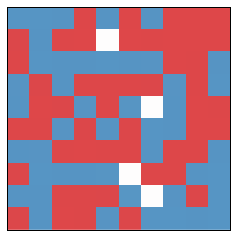

In [213]:
dgrid = Districts(10, cols=5, p=.2)
viewer = District_Viewer(dgrid)
viewer.draw(grid=False)
dgrid.segregation()

In [154]:
dgrid.net_wasted_votes()

12

In [155]:
dgrid.step()

0.48894444017267641

In [156]:
dgrid.net_wasted_votes()

12

Beginning simulation.
After 0::   segregation: 0.5016512105329243   efficiency gap: 0.383
After 1::   segregation: 0.5744897341172209   efficiency gap: 0.16613333333333333
After 2::   segregation: 0.663514966653626   efficiency gap: 0.05865555555555556
After 3::   segregation: 0.7327100321254049   efficiency gap: 0.0213
After 4::   segregation: 0.7780127960032174   efficiency gap: 0.021966666666666666
After 5::   segregation: 0.8107205600326843   efficiency gap: 0.021377777777777777
After 6::   segregation: 0.8313115713169882   efficiency gap: 0.021666666666666667
After 7::   segregation: 0.8464624942432672   efficiency gap: 0.014966666666666666
After 8::   segregation: 0.8566399482456004   efficiency gap: 0.015322222222222221
After 9::   segregation: 0.8648838771659061   efficiency gap: 0.051644444444444444
After 10::   segregation: 0.8706854446161246   efficiency gap: 0.05188888888888889
After 11::   segregation: 0.8749663216958591   efficiency gap: 0.05168888888888889
After 12::   s

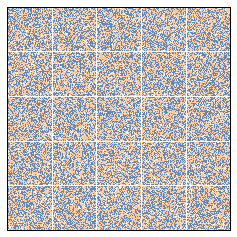

In [181]:
dgrid = Districts(300, cols=5, rows=5, p=.5, red_prob=0.47)
viewer = District_Viewer(dgrid)
viewer.draw(grid=True)
print("Beginning simulation.")
for i in range(50):
    print("After {}::   segregation: {}   efficiency gap: {}"
          .format(i, dgrid.segregation(), dgrid.efficiency_gap()))
    dgrid.step()

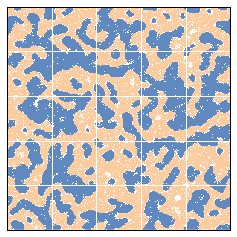

In [182]:
viewer.draw(grid=True)

In [130]:
np.array(3*[np.array(7*[np.array(1)])]) + np.array([np.array([1,1,1,0,1,1,1])])

array([[2, 2, 2, 1, 2, 2, 2],
       [2, 2, 2, 1, 2, 2, 2],
       [2, 2, 2, 1, 2, 2, 2]])

In [139]:
d = np.array(3*[np.ones(7)])

In [140]:
d

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.]])

In [149]:
np.array([1]*24 + [0] + [1]*24).reshape((7,7))

array([[1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1]])

In [145]:
np.reshape?